In [4]:
#Импортируем библиотеки
from multiprocessing import Pool
import codecs
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot
%matplotlib inline

In [5]:
data = pd.read_csv("posts_all.csv", encoding="utf-8")
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2081 entries, 0 to 2096
Data columns (total 3 columns):
id           2081 non-null object
text         2081 non-null object
Sentiment    2081 non-null float64
dtypes: float64(1), object(2)
memory usage: 65.0+ KB


,id,text,Sentiment
2092,4509,"Sorry, but this simply doesn't make sense. Th...",0.0
2093,4510,Dear \r\nI am not YET registered customer bu...,3.0
2094,4511,Why my question is not clear? \r\nDo not you ...,0.0
2095,4512,"Sorry for the delay, I've been out for some Ch...",0.0
2096,4512,Thanks for the reply. \r\n\> All the source f...,1.0


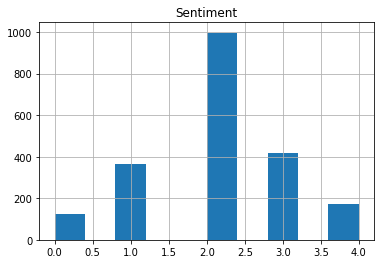

In [6]:
data.info()
#Гистограмма распределения классов 
data.hist(column=["Sentiment"])
data.tail()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E107779D68>]],
      dtype=object)

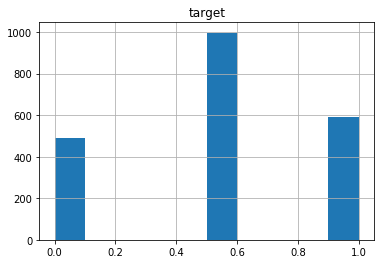

In [7]:
data["target"] = data.Sentiment.apply(lambda x: 1 if x > 2 else 0 if x < 2 else 0.5)
data.hist(column=["target"])

In [8]:
#The data store in really imbalanced
#Let's try the over sampling technice

import random 
classes = np.unique(data.target.values)
amount_classes = data.groupby("target").count().id.values
max_amount = max(amount_classes)
for cl_index in range(len(classes)):
    cl = classes[cl_index]
    cl_slice = data[data.target == cl]
    amount = amount_classes[cl_index]
    samples_to_add = max_amount - amount
    while samples_to_add > 0:
        sample_index = random.randint(0, amount - 1)

        data = data.append(cl_slice.iloc[sample_index])
        samples_to_add -= 1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 0 to 1449
Data columns (total 4 columns):
id           2991 non-null object
text         2991 non-null object
Sentiment    2991 non-null float64
target       2991 non-null float64
dtypes: float64(2), object(2)
memory usage: 116.8+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E1075B4710>]],
      dtype=object)

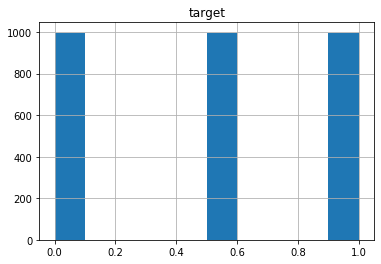

In [9]:
data.info()
data.hist(column=["target"])

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC

X = data.text.values
Y = data.target.values

In [11]:
#Импортируем доп библиотеки
from sklearn.pipeline import Pipeline
#Подбор лучших параметров
from sklearn.model_selection import GridSearchCV

#Функция создания каскада - пайплайна из ветроризатора, трансформатора и класификатора
def text_classifier(vectorizer, classifier, transformer=None):
    if (transformer is None) :
        return Pipeline(
                [("vectorizer", vectorizer),
                 ("classifier", classifier)]
            )
    else: 
        return Pipeline(
            [("vectorizer", vectorizer),
             ("transformer", transformer),
            ("classifier", classifier)]
        )

In [12]:
# the best parameters search for the level 1 estimator
ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LinearRegression()],
    #"vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LinearSVC())
gridSearchCV = GridSearchCV(pipLine, scoring="max_error", 
                            param_grid=param_grid,
                            cv=5,
                           )
gridSearchCV.fit(X, Y)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params {'classifier': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(4, 6), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (4, 6), 'vectorizer__stop_words': 'english'}
best score -0.6284428059730114


In [13]:
# the best parameters search for the level 2 estimator

Y_classes = data.Sentiment.values

ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LogisticRegression(multi_class="multinomial", 
                                      solver="lbfgs",
                                      max_iter=120   
                                     )],
    #"vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LogisticRegression())
gridSearchCV = GridSearchCV(pipLine, 
                            cv=5,
                            param_grid=param_grid)
gridSearchCV.fit(X, Y_classes)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

best params {'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=120,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'vectorizer': CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(4, 6), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None), 'vectorizer__analyzer': 'char_wb', 'vectorizer__ngram_range': (4, 6), 'vectorizer__stop_words': None}
best score 0.8739551989301237


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [25]:
from sklearn.model_selection import train_test_split
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(4, 6), max_df=0.95, stop_words='english')
X_vec = vectorizer.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, test_size=0.33)


linear_classifier = LinearRegression()
linear_classifier.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
print("Train",
      linear_classifier.score(X_train, Y_train),
      "Test",
      linear_classifier.score(X_test, Y_test))

Train 0.7155994110958187 Test 0.4092850837655456


In [27]:
l2_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(4, 6), max_df=0.95)
X_vec_l2 = l2_vectorizer.fit_transform(X)

linear_estimation = np.array([list([v]) for v in linear_classifier.predict(X_vec)])
X_epanded = np.hstack((X_vec_l2.toarray(), linear_estimation))
Y_classes = data.Sentiment.apply(lambda x: 1 if x > 2 else -1 if x < 2 else 0).values

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_epanded, Y_classes, test_size=0.33)


log_classifier = LogisticRegression(solver="lbfgs", 
                                    multi_class="ovr")
log_classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
print("Train",
      log_classifier.score(X_train, Y_train),
      "Test",
      log_classifier.score(X_test, Y_test))

print(cross_val_score(log_classifier, X_epanded, Y_classes, cv=5))

Train 0.9985022466300549 Test 0.9311740890688259
[0.92       0.915      0.94639866 0.9681742  0.89112228]


In [30]:
print(len(X) - 1)
test_index = 1345
print(X[test_index],
      "Prediction - ",
      log_classifier.predict([X_epanded[test_index]])[0])
print("The real value is - ",
     Y_classes[test_index])
print(log_classifier.predict_proba([X_epanded[test_index]]))

2990
Without people like you I really don't think we would ever advance.  Prediction -  1
The real value is -  1
[[0.05574553 0.00119773 0.94305674]]


In [31]:
import pickle
#Сохранение данных в файл с помощью pickle
pickle.dump(linear_classifier, open( "l1_Classifier.pkl", "wb" ))
pickle.dump(vectorizer, open( "l1_vectorizer.pkl", "wb" ))
pickle.dump(log_classifier, open( "l2_Classifier.pkl", "wb" ))
pickle.dump(l2_vectorizer, open( "l2_vectorizer.pkl", "wb" ))